In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# 设置随机种子
np.random.seed(42)

In [3]:
# 加载模型和标准化器
best_xgb = joblib.load('bf_w.pkl')
scaler = joblib.load('scaler_bf_w.pkl')

In [4]:
# 加载新数据
new_data = pd.read_csv('诊疗全_扩展.csv')
#new_data = pd.read_excel('预测+语义增强.xlsx')

In [5]:
# 提取结构化特征
X_new = new_data[['LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67', '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况','手术方式','放疗', '化疗期间是否应用诺雷德', '靶向治疗（赫赛汀或赫赛汀+帕捷特）','化疗方案', '内分泌治疗方案','Text_Embedding_Combined1','Text_Embedding_Combined2']]

In [6]:
# 标准化连续变量
continuous_vars = ['PR', 'ki-67', 'Text_Embedding_Combined1','Text_Embedding_Combined2']
X_new[continuous_vars] = scaler.transform(X_new[continuous_vars])

In [7]:
# 预测概率
y_new_proba = best_xgb.predict_proba(X_new)[:, 1]

In [8]:
# 添加到原始表格中
new_data['预后预测概率'] = y_new_proba

In [9]:
# 保存新表格
# new_data.to_excel('预测+语义增强+预测概率.xlsx', index=False)
# print("✅ 已完成预测，结果已保存为 '预测+语义增强+预测概率.xlsx'")
new_data.to_csv('诊疗全_预测结果.csv', index=False)
print("✅ 已完成预测，结果已保存为 '诊疗全_预测结果.csv'")

✅ 已完成预测，结果已保存为 '预测+语义增强+预测概率.xlsx'


In [1]:
import pandas as pd

In [2]:
# # 读取已预测好的数据
df = pd.read_csv('诊疗全_预测结果.csv')

In [3]:
# 定义唯一标识一个病人的特征列（不包含诊疗方案）
patient_id_cols = ['LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67', 
                   '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况', 'Text_Embedding_Combined1','Text_Embedding_Combined2']

In [4]:
# 1. 对每个病人按概率从小到大排序（相同病人的不同治疗组合）
df_sorted = df.sort_values(by=patient_id_cols + ['预后预测概率'])

In [5]:
# 分组排序：每个病人组内按预测概率升序排序
df_ranked = df_sorted.groupby(patient_id_cols, as_index=False).apply(lambda x: x.sort_values(by='预后预测概率')).reset_index(drop=True)

In [6]:
# 保存每个病人不同诊疗手段的预测排序结果
df_ranked.to_csv('诊疗全_预测结果_分组排序.csv', index=False)

In [7]:
# 2. 获取每位病人预测概率最小的3种诊疗组合（即排序后的前3条）
df_top3_plan = df_ranked.groupby(patient_id_cols, as_index=False).head(3)

In [8]:
# 保存每个病人最优（预后概率最小）诊疗组合
df_top3_plan.to_excel('诊疗全_预测结果_病人最优三种诊疗组合.xlsx', index=False)

In [46]:
import pandas as pd

# 加载数据
actual_df = pd.read_excel('预测+语义增强.xlsx')   # 每人一行
recommend_df = pd.read_excel('诊疗全_预测结果_病人最优三种诊疗组合.xlsx') # 每人三行（可能重复）

# 患者唯一标识用以下特征组合
patient_keys = ['LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67',
                '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况',
                'Text_Embedding_Combined1','Text_Embedding_Combined2']
actual_col = '内分泌治疗方案'
recommend_col = '内分泌治疗方案'

In [47]:
# 类型标准化（去空格、小写、保留4位小数）
for col in patient_keys + [actual_col, recommend_col]:
    if actual_df[col].dtype == 'object':
        actual_df[col] = actual_df[col].astype(str).str.strip().str.lower()
        recommend_df[col] = recommend_df[col].astype(str).str.strip().str.lower()
    else:
        actual_df[col] = pd.to_numeric(actual_df[col], errors='coerce').round(4)
        recommend_df[col] = pd.to_numeric(recommend_df[col], errors='coerce').round(4)

In [48]:
# 添加 group_key 用作“患者唯一标识”
actual_df['group_key'] = actual_df[patient_keys].apply(lambda row: tuple(row), axis=1)
recommend_df['group_key'] = recommend_df[patient_keys].apply(lambda row: tuple(row), axis=1)

In [49]:
actual_map = actual_df.drop_duplicates(subset='group_key').set_index('group_key')[actual_col].to_dict()

In [50]:
len(actual_map)

1366

In [51]:
recommend_grouped = recommend_df.groupby('group_key')[recommend_col].apply(list).to_dict()

In [52]:
len(recommend_grouped)

1366

In [53]:
# 对每个患者判断是否匹配成功
results = []
for group_key, rec_list in recommend_grouped.items():
    if group_key in actual_map:
        actual = actual_map[group_key]
        match = actual in rec_list
        results.append({
            'group_key': group_key,
            '实际手术方式': actual,
            '推荐手术方式列表': rec_list,
            '是否匹配': match
        })

In [54]:
# 转换为 DataFrame
result_df = pd.DataFrame(results)

# 输出匹配结果
match_count = result_df['是否匹配'].sum()
total_count = len(result_df)
print(f"总患者数：{total_count}")
print(f"推荐成功的患者数：{match_count}")
print(f"推荐成功率：{match_count / total_count:.2%}")

总患者数：1366
推荐成功的患者数：757
推荐成功率：55.42%


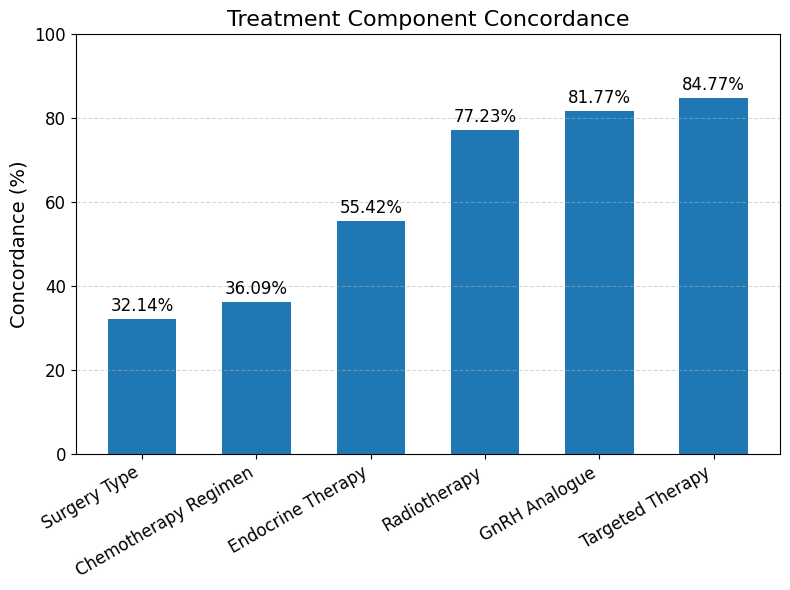

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
components = [
    'Surgery Type', 
    'Chemotherapy Regimen', 
    'Endocrine Therapy', 
    'Radiotherapy', 
    'GnRH Analogue', 
    'Targeted Therapy'
]
concordance = [32.14, 36.09, 55.42, 77.23, 81.77, 84.77]

# 坐标
x = np.arange(len(components))

# 图像设置
plt.figure(figsize=(8, 6))
bars = plt.bar(x, concordance, color='#1F78B4', width=0.6)

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12)

# 设置标题和标签
plt.title('Treatment Component Concordance', fontsize=16)
plt.ylabel('Concordance (%)', fontsize=14)
plt.xticks(x, components, fontsize=12, rotation=30, ha='right')
plt.yticks(fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# 保存为矢量图 PDF 和 SVG
#plt.savefig("Treatment_Concordance_BarChart.pdf", format='pdf', dpi=300)
plt.savefig("Treatment_Concordance_BarChart.svg", format='svg', dpi=300)

# 显示图像
plt.show()

In [1]:
import pandas as pd

# 加载两个表格
df_actual = pd.read_excel('预测+语义增强+预测概率.xlsx')
df_recommend = pd.read_excel('诊疗全_预测结果_病人最优三种诊疗组合.xlsx')

# 患者特征列（用于唯一匹配）
patient_features = ['LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67',  
                    '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况',
                    'Text_Embedding_Combined1','Text_Embedding_Combined2']

In [2]:
# 类型标准化（去空格、小写、保留4位小数）
for col in patient_features:
    if df_actual[col].dtype == 'object':
        df_actual[col] = df_actual[col].astype(str).str.strip().str.lower()
        df_recommend[col] = df_recommend[col].astype(str).str.strip().str.lower()
    else:
        df_actual[col] = pd.to_numeric(df_actual[col], errors='coerce').round(4)
        df_recommend[col] = pd.to_numeric(df_recommend[col], errors='coerce').round(4)

In [3]:
# 获取每位患者的实际手术方式（以特征元组为键）
actual_surgery_dict = df_actual.set_index(patient_features)['内分泌治疗方案'].to_dict()

In [4]:
# 在推荐表中为每行添加实际手术方式列（通过映射）
df_recommend['实际内分泌治疗方案'] = df_recommend[patient_features].apply(
    lambda row: actual_surgery_dict.get(tuple(row), None), axis=1
)

In [5]:
# 标记出匹配成功的患者（推荐中至少有一个匹配）
matched_patients = df_recommend[df_recommend['内分泌治疗方案'] == df_recommend['实际内分泌治疗方案']]

In [6]:
# 找到需要剔除的患者特征组合（即推荐中有匹配的）
patients_to_remove = matched_patients[patient_features].drop_duplicates()

In [7]:
# 用 merge 的方式，从推荐表中删除这些患者的所有推荐记录
df_filtered = df_recommend.merge(patients_to_remove, on=patient_features, how='left', indicator=True)
df_filtered = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge', '内分泌治疗方案'])

In [8]:
# 从实际表中也删除这些患者
df_filtered_actual = df_actual.merge(patients_to_remove, on=patient_features, how='left', indicator=True)
df_filtered_actual = df_filtered_actual[df_filtered_actual['_merge'] == 'left_only'].drop(columns=['_merge'])
df_filtered_actual.to_excel("剔除匹配患者后实际数据_内分泌治疗方案.xlsx", index=False)

In [9]:
# 保存结果
df_filtered.to_excel("推荐失败_内分泌治疗方案.xlsx", index=False)

In [6]:
import pandas as pd

# 读取数据
df = pd.read_excel('推荐失败_手术方式.xlsx')  # 或你正在处理的任意数据表

# 分组依据
group_cols = ['LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67',
              '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况',
              'Text_Embedding_Combined1','Text_Embedding_Combined2']

target_col = '预后预测概率'  # 替换成你的实际预测值列名

# 类型标准化（推荐，防止分组错误）
for col in group_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip().str.lower()
    else:
        df[col] = pd.to_numeric(df[col], errors='coerce').round(4)

# 将预测概率转为数值型并保留4位小数
df[target_col] = pd.to_numeric(df[target_col], errors='coerce').round(4)

# 找到每组中预测概率最小的行
idx_min = df.groupby(group_cols)[target_col].idxmin()
df_min = df.loc[idx_min].reset_index(drop=True)

# 输出结果
print(f"原始样本数：{df.shape[0]}")
print(f"保留最优样本数（每组一条）：{df_min.shape[0]}")


df_min.to_excel("手术方式保留预测最小行.xlsx", index=False)

原始样本数：2781
保留最优样本数（每组一条）：927


Surgery Type：匹配成功 927 人
Chemotherapy Regimen：匹配成功 873 人
Endocrine Therapy：匹配成功 609 人
Radiotherapy：匹配成功 311 人
GnRH Analogue：匹配成功 249 人
Targeted Therapy：匹配成功 208 人


<ipython-input-1-1bbf3faa0c00>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


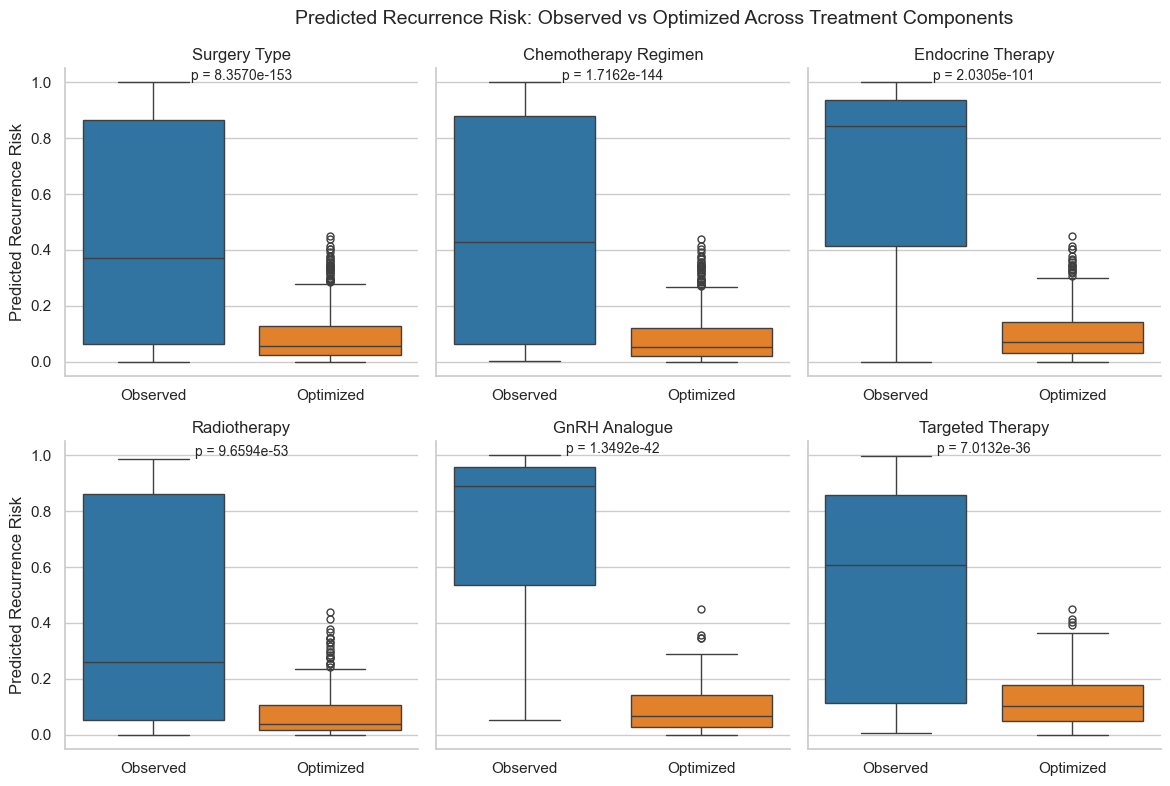

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# 中文支持（可根据系统字体调整）
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体，如无中文可设为 'Arial'
# plt.rcParams['axes.unicode_minus'] = False

# 匹配特征
patient_features = [
    'LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67',
    '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况',
    'Text_Embedding_Combined1','Text_Embedding_Combined2'
]

# 各维度及其文件映射
dimensions = {
    'Surgery Type':      ('剔除匹配患者后实际数据_手术方式.xlsx', '手术方式保留预测最小行.xlsx'),
    'Chemotherapy Regimen':      ('剔除匹配患者后实际数据_化疗方案.xlsx', '化疗方案保留预测最小行.xlsx'),
    'Endocrine Therapy':    ('剔除匹配患者后实际数据_内分泌治疗方案.xlsx', '内分泌治疗方案保留预测最小行.xlsx'),
    'Radiotherapy':         ('剔除匹配患者后实际数据_放疗.xlsx', '放疗保留预测最小行.xlsx'),
    'GnRH Analogue':    ('剔除匹配患者后实际数据_化疗期间是否应用诺雷德.xlsx', '化疗期间是否应用诺雷德保留预测最小行.xlsx'),
    'Targeted Therapy':      ('剔除匹配患者后实际数据_靶向治疗（赫赛汀或赫赛汀+帕捷特）.xlsx', '靶向治疗（赫赛汀或赫赛汀+帕捷特）保留预测最小行.xlsx'),
}

# 收集所有绘图数据
all_data = []

for dim_name, (actual_file, optimized_file) in dimensions.items():
    df_actual = pd.read_excel(actual_file)
    df_optimized = pd.read_excel(optimized_file)

    # 合并数据
    df_merged = pd.merge(df_actual, df_optimized, on=patient_features, suffixes=('_actual', '_optimized'))
    print(f"{dim_name}：匹配成功 {len(df_merged)} 人")

    # 提取预测概率列（请根据你实际的列名修改）
    obs_col = '预后预测概率_actual'
    opt_col = '预后预测概率_optimized'

    # 转为长格式以便绘图
    df_melt = pd.melt(
        df_merged[[obs_col, opt_col]].rename(columns={obs_col: 'Observed', opt_col: 'Optimized'}),
        value_vars=['Observed', 'Optimized'],
        var_name='Regimen_Type',
        value_name='Predicted Recurrence Risk'
    )
    df_melt['Treatment_Component'] = dim_name
    all_data.append(df_melt)

# 合并所有维度数据
df_all = pd.concat(all_data, ignore_index=True)

# 设置画图风格
sns.set(style="whitegrid")

# 分面绘图
g = sns.catplot(
    x='Regimen_Type',
    y='Predicted Recurrence Risk',
    col='Treatment_Component',
    data=df_all,
    kind='box',
    palette=['#1f77b4', '#ff7f0e'],
    col_wrap=3,
    height=4,
    aspect=1,
    sharex=False
)
g.set_axis_labels("", "Predicted Recurrence Risk")

# 添加主标题
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle('Predicted Recurrence Risk: Observed vs Optimized Across Treatment Components', fontsize=14)

# 可选：对每个子图添加Wilcoxon检验p值
for ax, dim_name in zip(g.axes.flatten(), dimensions.keys()):
    df_obs = df_all[(df_all['Treatment_Component'] == dim_name) & (df_all['Regimen_Type'] == 'Observed')]['Predicted Recurrence Risk']
    df_opt = df_all[(df_all['Treatment_Component'] == dim_name) & (df_all['Regimen_Type'] == 'Optimized')]['Predicted Recurrence Risk']
    
    # 避免0差异样本导致报错
    try:
        stat, p = wilcoxon(df_obs, df_opt)
        ax.text(0.5, max(df_obs.max(), df_opt.max()) + 0.01,
                f'p = {p:.4e}', ha='center', fontsize=10)
    except:
        ax.text(0.5, max(df_obs.max(), df_opt.max()) + 0.01,
                'p = N/A', ha='center', fontsize=10)
        
    # 设置标题为中英结合形式
    eng_name = f'{dim_name}'
    ax.set_title(eng_name, fontsize=12)
  

g._legend.remove()

# 展示图形
g.tight_layout()

g.savefig("recurrence_comparison.svg", format="svg", bbox_inches="tight")

plt.show()

In [1]:
import pandas as pd

# 设定匹配用的唯一特征列
patient_features = [
    'LN转移个数','腋窝淋巴结状态','PR', 'HER2+FISH', 'ki-67',
    '手术前怀孕', '治疗后怀孕', '治疗后生产','目前月经情况',
    'Text_Embedding_Combined1','Text_Embedding_Combined2'
]

# 所有治疗维度及其对应的文件名
dimensions = {
    'Surgery Type': ('剔除匹配患者后实际数据_手术方式.xlsx', '手术方式保留预测最小行.xlsx'),
    'Chemotherapy Regimen': ('剔除匹配患者后实际数据_化疗方案.xlsx', '化疗方案保留预测最小行.xlsx'),
    'Endocrine Therapy': ('剔除匹配患者后实际数据_内分泌治疗方案.xlsx', '内分泌治疗方案保留预测最小行.xlsx'),
    'Radiotherapy': ('剔除匹配患者后实际数据_放疗.xlsx', '放疗保留预测最小行.xlsx'),
    'GnRH Analogue': ('剔除匹配患者后实际数据_化疗期间是否应用诺雷德.xlsx', '化疗期间是否应用诺雷德保留预测最小行.xlsx'),
    'Targeted Therapy': ('剔除匹配患者后实际数据_靶向治疗（赫赛汀或赫赛汀+帕捷特）.xlsx', '靶向治疗（赫赛汀或赫赛汀+帕捷特）保留预测最小行.xlsx'),
}

# 用于存储结果
results = []

for dim, (actual_file, optimized_file) in dimensions.items():
    # 读取实际和最优数据
    df_actual = pd.read_excel(actual_file)
    df_optimized = pd.read_excel(optimized_file)
    
    # 匹配合并
    df_merged = pd.merge(df_actual, df_optimized, on=patient_features, suffixes=('_actual', '_optimized'))
    
    # 取预测概率列
    actual_col = '预后预测概率_actual'
    optimized_col = '预后预测概率_optimized'
    
    # 计算差值（实际 - 最优），单位是概率
    delta = df_merged[actual_col] - df_merged[optimized_col]
    
    # 转换为百分比
    delta_pct = delta * 100
    
    # 计算中位数与IQR
    median_reduction = delta_pct.median()
    q1 = delta_pct.quantile(0.25)
    q3 = delta_pct.quantile(0.75)
    
    results.append({
        'Dimension': dim,
        'Median Reduction (%)': round(median_reduction, 2),
        'IQR (%)': f"{round(q1, 2)} – {round(q3, 2)}",
        'N Matched Patients': len(df_merged)
    })

# 输出为DataFrame
df_result = pd.DataFrame(results)
print(df_result)

              Dimension  Median Reduction (%)        IQR (%)  \
0          Surgery Type                 25.71   3.01 – 70.88   
1  Chemotherapy Regimen                 30.80   3.01 – 73.72   
2     Endocrine Therapy                 69.67   30.8 – 84.98   
3          Radiotherapy                 15.34   2.65 – 71.42   
4         GnRH Analogue                 75.15  39.22 – 88.09   
5      Targeted Therapy                 41.19   5.41 – 67.73   

   N Matched Patients  
0                 927  
1                 873  
2                 609  
3                 311  
4                 249  
5                 208  


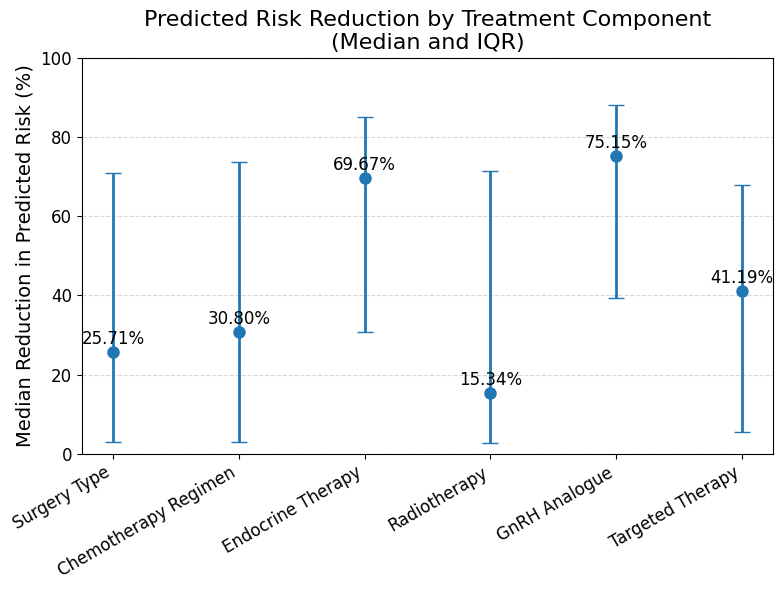

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
components = [
    'Surgery Type', 'Chemotherapy Regimen', 'Endocrine Therapy',
    'Radiotherapy', 'GnRH Analogue', 'Targeted Therapy'
]

# 中位数
medians = np.array([25.71, 30.80, 69.67, 15.34, 75.15, 41.19])

# IQR（下限，上限）
iqr_lows = np.array([3.01, 3.01, 30.8, 2.65, 39.22, 5.41])
iqr_highs = np.array([70.88, 73.72, 84.98, 71.42, 88.09, 67.73])

# 计算误差条（相对中位数）
yerr = np.array([medians - iqr_lows, iqr_highs - medians])

# 坐标
x = np.arange(len(components))

# 图像设置（大小与柱状图一致）
plt.figure(figsize=(8, 6))
plt.errorbar(x, medians, yerr=yerr, fmt='o', color='#1F78B4', capsize=6,
             markersize=8, linewidth=2)

# 添加数值标签
for i, med in enumerate(medians):
    plt.text(x[i], med + 2, f'{med:.2f}%', ha='center', fontsize=12)

# 坐标轴和标签设置
plt.xticks(x, components, fontsize=12, rotation=30, ha='right')
plt.yticks(fontsize=12)
plt.ylabel('Median Reduction in Predicted Risk (%)', fontsize=14)
plt.title('Predicted Risk Reduction by Treatment Component\n(Median and IQR)', fontsize=16)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# 保存为矢量图 PDF 和 SVG
#plt.savefig("Risk_Reduction_DotPlot.pdf", format='pdf', dpi=300)
plt.savefig("Risk_Reduction_DotPlot.svg", format='svg', dpi=300)

# 显示图像
plt.show()